In [1]:
from Bio import SeqIO
import pandas as pd

In [2]:
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/submission.tsv
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/__results__.html
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/__resultx__.html
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/__notebook__.ipynb
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/__output__.json
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/custom.css
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/__results___files/__results___36_0.png
/kaggle/input/proteinet-pytorch-ems2-t5-protbert-embeddings/__results___files/__results___36_1.png
/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-fun

In [3]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 18
    batch_size = 128
    lr = 0.01
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print("Load ProtBERT Model...")
# PROT BERT LOADING :
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(config.device)

Load ProtBERT Model...


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# def get_bert_embedding(
#     sequence : str,
#     len_seq_limit : int
# ):
#     '''
#     Function to collect last hidden state embedding vector from pre-trained ProtBERT Model

#     INPUTS:
#     - sequence (str) : protein sequence (ex : AAABBB) from fasta file
#     - len_seq_limit (int) : maximum sequence lenght (i.e nb of letters) for truncation

#     OUTPUTS:
#     - output_hidden : last hidden state embedding vector for input sequence of length 1024
#     '''
#     sequence_w_spaces = ' '.join(list(sequence))
#     encoded_input = tokenizer(
#         sequence_w_spaces,
#         truncation=True,
#         max_length=len_seq_limit,
#         padding='max_length',
#         return_tensors='pt').to(config.device)
#     output = model(**encoded_input)
#     output_hidden = output['last_hidden_state'][:,0][0].detach().cpu().numpy()
#     assert len(output_hidden)==1024
#     return output_hidden

In [6]:
# ### COLLECTING FOR TRAIN SAMPLES :
# print("Loading train set ProtBERT Embeddings...")
# fasta_train = SeqIO.parse(config.train_sequences_path, "fasta")
# print("Total Nb of Elements : ", len(list(fasta_train)))
# fasta_train = SeqIO.parse(config.train_sequences_path, "fasta")
# ids_list = []
# embed_vects_list = []
# t0 = time.time()
# checkpoint = 0
# for item in tqdm(fasta_train):
#     ids_list.append(item.id)
#     embed_vects_list.append(
#         get_bert_embedding(sequence = item.seq, len_seq_limit = 1200))
#     checkpoint+=1
#     if checkpoint>=100:
#         df_res = pd.DataFrame(data={"id" : ids_list, "embed_vect" : embed_vects_list})
#         np.save('/kaggle/working/train_ids.npy',np.array(ids_list))
#         np.save('/kaggle/working/train_embeddings.npy',np.array(embed_vects_list))
#         checkpoint=0

# np.save('/kaggle/working/train_ids.npy',np.array(ids_list))
# np.save('/kaggle/working/train_embeddings.npy',np.array(embed_vects_list))
# print('Total Elapsed Time:',time.time()-t0)

In [7]:
# ### COLLECTING FOR TEST SAMPLES :
# print("Loading test set ProtBERT Embeddings...")
# fasta_test = SeqIO.parse(config.test_sequences_path, "fasta")
# print("Total Nb of Elements : ", len(list(fasta_test)))
# fasta_test = SeqIO.parse(config.test_sequences_path, "fasta")
# ids_list = []
# embed_vects_list = []
# t0 = time.time()
# checkpoint=0
# for item in tqdm(fasta_test):
#     ids_list.append(item.id)
#     embed_vects_list.append(
#         get_bert_embedding(sequence = item.seq, len_seq_limit = 1200))
#     checkpoint+=1
#     if checkpoint>=100:
#         np.save('/kaggle/working/test_ids.npy',np.array(ids_list))
#         np.save('/kaggle/working/test_embeddings.npy',np.array(embed_vects_list))
#         checkpoint=0

# np.save('/kaggle/working/test_ids.npy',np.array(ids_list))
# np.save('/kaggle/working/test_embeddings.npy',np.array(embed_vects_list))
# print('Total Elasped Time:',time.time()-t0)

In [8]:
print("GENERATE TARGETS FOR ENTRY IDS ("+str(config.num_labels)+" MOST COMMON GO TERMS)")
ids = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy")
labels = pd.read_csv(config.train_labels_path, sep = "\t")

top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
labels_names = top_terms[:config.num_labels].index.values
train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()

go_terms_map = {label: i for i, label in enumerate(labels_names)}
labels_matrix = np.empty((len(ids), len(labels_names)))

for index, id in tqdm(enumerate(ids)):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1

np.save("/kaggle/working/train_targets_top"+str(config.num_labels)+".npy", np.array(labels_matrix))
print("GENERATION FINISHED!")

GENERATE TARGETS FOR ENTRY IDS (500 MOST COMMON GO TERMS)


142246it [01:03, 2227.71it/s]


GENERATION FINISHED!


In [9]:
# import pickle

# # Assuming you already have the variables 'labels', 'id_labels', and 'labels_names' from your previous code
# # Ensure that 'labels_names' contains the top 500 most common GO terms

# # Filter the 'labels' DataFrame to keep only the top 500 most common GO terms
# top_500_labels = labels[labels['term'].isin(labels_names)]

# # Save 'top_500_labels' and 'id_labels' to a dictionary
# data_dict = {'top_500_labels': top_500_labels, 'id_labels': id_labels}

# # Define the filename for the pickle file
# pickle_file = "/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl"

# # Open the file in binary write mode and save the data_dict
# with open(pickle_file, 'wb') as f:
#     pickle.dump(data_dict, f)

# print("Pickle file created successfully at:", pickle_file)


In [10]:
# import pandas as pd

# # Load the pickled dictionary
# data_dict = pd.read_pickle("/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl")

# # Get the number of entries (assuming the dictionary is the same as DataFrame rows)
# num_entries = len(data_dict)
# print("Number of entries:", num_entries)

# # Get the dimensions of the dictionary (if the value is a pandas DataFrame or similar)
# dimensions = {}
# for key, value in data_dict.items():
#     if isinstance(value, pd.DataFrame) or isinstance(value, pd.Series):
#         dimensions[key] = value.shape
#     elif isinstance(value, list):
#         dimensions[key] = len(value)
#     else:
#         dimensions[key] = "Unknown"

# print("Dimensions of the dictionary:")
# for key, value in dimensions.items():
#     print(f"Key: {key}, Dimensions: {value}")


In [11]:
# class ProteinSequenceDataset(Dataset):
    
#     def __init__(self, datatype, embeddings_source):
#         super(ProteinSequenceDataset).__init__()
#         self.datatype = datatype
        
#         if embeddings_source in ["ProtBERT", "EMS2"]:
#             embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
#             ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
#         if embeddings_source == "T5":
#             embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
#             ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
#         embeds_list = []
#         for l in range(embeds.shape[0]):
#             embeds_list.append(embeds[l,:])
#         self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
#         if datatype=="train":
#             df_labels = pd.read_pickle(
#                 "/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl")

#             # Assuming self.df is your existing DataFrame and df_labels is the dictionary with "top_500_labels" and "id_labels" keys
#             # Extract the "top_500_labels" DataFrame from the dictionary
#             df_labels = df_labels["top_500_labels"]

#             # Merge the two DataFrames on "EntryID" column
#             self.df = self.df.merge(df_labels, on="EntryID")


#             # Merge the two DataFrames on "EntryID" column
#             #self.df = self.df.merge(df_labels, on="EntryID")
#             #self.df = self.df.merge(df_labels, on="EntryID")
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, index):
#         embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
#         if self.datatype=="train":
#             targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
#             return embed, targets
#         if self.datatype=="test":
#             id = self.df.iloc[index]["EntryID"]
#             return embed, id
        

In [12]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
        if embeddings_source == "T5":
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            df_labels = np.load("/kaggle/working/train_targets_top500.npy")
            self.df["labels_vect"] = df_labels.tolist()
            #self.df = self.df.merge(df_labels, on="EntryID")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id
        

In [13]:
# import torch
# from torch.utils.data import Dataset
# import numpy as np
# import pandas as pd

# class ProteinSequenceDataset(Dataset):
    
#     def __init__(self, datatype, embeddings_source):
#         super(ProteinSequenceDataset, self).__init__()
#         self.datatype = datatype
        
#         if embeddings_source in ["ProtBERT", "EMS2"]:
#             embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
#             ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
#         if embeddings_source == "T5":
#             embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
#             ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
#         embeds_list = []
#         for l in range(embeds.shape[0]):
#             embeds_list.append(embeds[l,:])
#         self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
#         if datatype == "train":
#             # Read df_labels as a DataFrame
#             #df_labels = pd.read_pickle("/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl")
#             df_labels = pd.read_pickle("/kaggle/working/train_targets_top500.pkl")
#             # Check if df_labels is a DataFrame and contains 'EntryID' and 'labels_vect' columns
#             if not isinstance(df_labels, pd.DataFrame) or "EntryID" not in df_labels.columns or "labels_vect" not in df_labels.columns:
#                 raise ValueError("Invalid df_labels format. It should be a DataFrame with 'EntryID' and 'labels_vect' columns.")
#             self.df = self.df.merge(df_labels, on="EntryID")
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, index):
#         embed = torch.tensor(self.df.iloc[index]["embed"], dtype=torch.float32)
#         if self.datatype == "train":
#             targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype=torch.float32)
#             return embed, targets
#         if self.datatype == "test":
#             entry_id = self.df.iloc[index]["EntryID"]
#             return embed, entry_id


In [14]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [15]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):
    
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [16]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280
}

In [17]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 1001/1001 [00:33<00:00, 29.51it/s]


Running Average TRAIN Loss :  138.12836127800423
Running Average TRAIN F1-Score :  0.09952495968737803
Running Average VAL Loss :  138.22681951522827
Running Average VAL F1-Score :  0.12204746316586222


EPOCH  2


100%|██████████| 1001/1001 [00:29<00:00, 33.85it/s]


Running Average TRAIN Loss :  135.99615704882277
Running Average TRAIN F1-Score :  0.12885572608712909
Running Average VAL Loss :  137.73274626050676
Running Average VAL F1-Score :  0.13744735531508923


EPOCH  3


100%|██████████| 1001/1001 [00:29<00:00, 34.18it/s]


Running Average TRAIN Loss :  135.33449469841682
Running Average TRAIN F1-Score :  0.13808137198517492
Running Average VAL Loss :  138.21979011808122
Running Average VAL F1-Score :  0.14067339784066593


EPOCH  4


100%|██████████| 1001/1001 [00:29<00:00, 34.16it/s]


Running Average TRAIN Loss :  134.9644132951399
Running Average TRAIN F1-Score :  0.1423766935741032
Running Average VAL Loss :  138.0634389604841
Running Average VAL F1-Score :  0.14345647980059897


EPOCH  5


100%|██████████| 1001/1001 [00:29<00:00, 34.00it/s]


Running Average TRAIN Loss :  133.77718761036326
Running Average TRAIN F1-Score :  0.15284399577341118
Running Average VAL Loss :  135.48505204064506
Running Average VAL F1-Score :  0.1550299571827054


EPOCH  6


100%|██████████| 1001/1001 [00:29<00:00, 34.12it/s]


Running Average TRAIN Loss :  133.48772893823707
Running Average TRAIN F1-Score :  0.1556777313991741
Running Average VAL Loss :  136.08940199443273
Running Average VAL F1-Score :  0.15888097815747773


EPOCH  7


100%|██████████| 1001/1001 [00:29<00:00, 33.99it/s]


Running Average TRAIN Loss :  133.4063641512906
Running Average TRAIN F1-Score :  0.1566887392655953
Running Average VAL Loss :  135.68329661233085
Running Average VAL F1-Score :  0.1592092916502484


EPOCH  8


100%|██████████| 1001/1001 [00:29<00:00, 34.18it/s]


Running Average TRAIN Loss :  133.15598341325423
Running Average TRAIN F1-Score :  0.15801899545229636
Running Average VAL Loss :  135.47861964362008
Running Average VAL F1-Score :  0.15890183126819984


EPOCH  9


100%|██████████| 1001/1001 [00:29<00:00, 33.61it/s]


Running Average TRAIN Loss :  133.12910599379867
Running Average TRAIN F1-Score :  0.1583502212023878
Running Average VAL Loss :  135.2771806716919
Running Average VAL F1-Score :  0.15880086153213466


EPOCH  10


100%|██████████| 1001/1001 [00:29<00:00, 34.15it/s]


Running Average TRAIN Loss :  133.1189535333441
Running Average TRAIN F1-Score :  0.15867484110099572
Running Average VAL Loss :  135.52039561952864
Running Average VAL F1-Score :  0.15934781324384467


EPOCH  11


100%|██████████| 1001/1001 [00:29<00:00, 34.10it/s]


Running Average TRAIN Loss :  133.10077248038826
Running Average TRAIN F1-Score :  0.1588178798779622
Running Average VAL Loss :  135.79457242148263
Running Average VAL F1-Score :  0.16005157599491732


EPOCH  12


100%|██████████| 1001/1001 [00:29<00:00, 34.16it/s]


Running Average TRAIN Loss :  133.1059628771497
Running Average TRAIN F1-Score :  0.15883655070544003
Running Average VAL Loss :  135.2766945021493
Running Average VAL F1-Score :  0.15866563908223594


EPOCH  13


100%|██████████| 1001/1001 [00:29<00:00, 34.14it/s]


Running Average TRAIN Loss :  133.0744325864565
Running Average TRAIN F1-Score :  0.15883041389070668
Running Average VAL Loss :  135.4244394983564
Running Average VAL F1-Score :  0.16037754268784607


EPOCH  14


100%|██████████| 1001/1001 [00:29<00:00, 34.14it/s]


Running Average TRAIN Loss :  133.07636440097988
Running Average TRAIN F1-Score :  0.1591512992918551
Running Average VAL Loss :  135.58456332342965
Running Average VAL F1-Score :  0.15927956785474504


EPOCH  15


100%|██████████| 1001/1001 [00:29<00:00, 34.13it/s]


Running Average TRAIN Loss :  133.16253313032183
Running Average TRAIN F1-Score :  0.1591790429615117
Running Average VAL Loss :  135.4414530481611
Running Average VAL F1-Score :  0.15941322960757784


EPOCH  16


100%|██████████| 1001/1001 [00:29<00:00, 34.11it/s]


Running Average TRAIN Loss :  133.102527256374
Running Average TRAIN F1-Score :  0.15912898751971247
Running Average VAL Loss :  135.37466750826155
Running Average VAL F1-Score :  0.16015799835856473


EPOCH  17


100%|██████████| 1001/1001 [00:29<00:00, 33.94it/s]


Running Average TRAIN Loss :  133.10153845330694
Running Average TRAIN F1-Score :  0.15888307586714223
Running Average VAL Loss :  136.1646035058158
Running Average VAL F1-Score :  0.1601372824183532


EPOCH  18


100%|██████████| 1001/1001 [00:29<00:00, 34.06it/s]


Running Average TRAIN Loss :  133.1079959621677
Running Average TRAIN F1-Score :  0.15919021803599137
Running Average VAL Loss :  135.51618228639876
Running Average VAL F1-Score :  0.15924392780289054


TRAINING FINISHED
FINAL TRAINING SCORE :  0.15919021803599137
FINAL VALIDATION SCORE :  0.15924392780289054


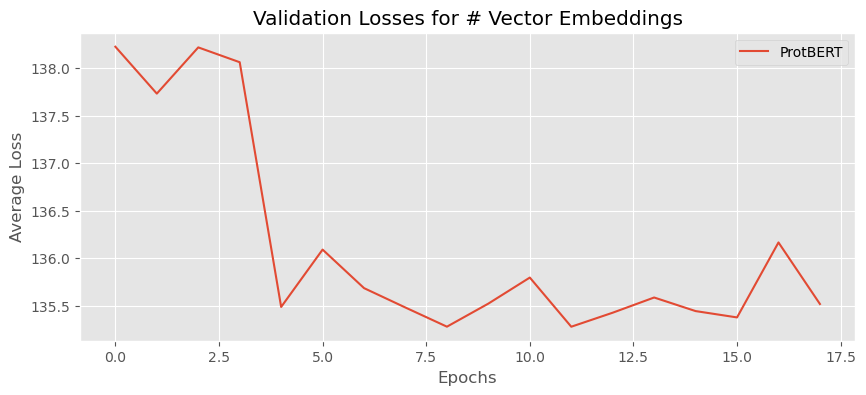

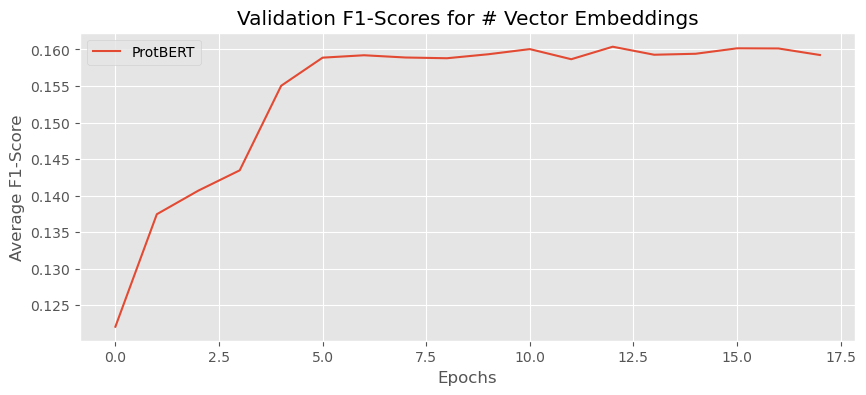

In [18]:
plt.figure(figsize = (10, 4))
plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [19]:
def predict(embeddings_source):
    
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model
        
    model.eval()
    
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [20]:
submission_df = predict("ProtBERT")

GENERATE PREDICTION FOR TEST SET...


141865it [01:28, 1604.38it/s]


PREDICTIONS DONE


In [21]:
#np.save("pred.npy", submission_df)

In [22]:
submission_df

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.906818
1,Q9CQV8,GO:0008150,0.903472
2,Q9CQV8,GO:0110165,0.905195
3,Q9CQV8,GO:0003674,0.880664
4,Q9CQV8,GO:0005622,0.894402
...,...,...,...
70932495,A0A3G2FQK2,GO:0044403,0.786492
70932496,A0A3G2FQK2,GO:0042803,0.166554
70932497,A0A3G2FQK2,GO:0016829,0.037005
70932498,A0A3G2FQK2,GO:0090596,0.182513


In [23]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)